In [404]:
#imports
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from networkx.readwrite import json_graph
from matplotlib.pyplot import figure
import numpy as np
import json
from openpyxl import load_workbook
from unicodedata import normalize


In [405]:
dir = "planilhas/"

def get_file_name(filepath):
    """Lista os arquivos da pasta"""
    f = os.listdir(filepath)
    files = [os.path.splitext(filename)[0] for filename in os.listdir(dir)]
    return files

In [406]:
def get_sheet_names_xlsx(filepath):
    """Lista a sheet do arquivo"""
    wb = load_workbook(filepath, read_only=True, keep_links=False)
    return wb.sheetnames

In [407]:
def get_all_files():
    """Loop para listar todos os arquivos e suas sheets
def get_all_files():"""
    f = np.array(get_file_name(dir))
    sheets = []
    file_name = []
    for i in range(len(f)):
        file_name.append(f.item(i))
        s = get_sheet_names_xlsx(dir+file_name[i]+".xlsx")
        s_as_string = ' '.join([str(elem) for elem in s])   #converte a lista para string
        sheets.append(s_as_string)                          #nova lista
    print("Files: {}".format(file_name))
    print("Sheets: {}".format(sheets))
    return convert_all_to_json(dir, file_name, sheets, ".xlsx")

In [408]:
def convert_to_json(dir, file_name, sheet_name, ext):
    """Converte excel para Json"""
    excel_data_df = pd.read_excel(dir + file_name + ext, sheet_name=sheet_name)
    json_str = excel_data_df.to_json(orient='records')
    #print("The original dictionary is : {}".format(json_str))
    return handle_accentuation_json(json_str)

In [409]:
def handle_accentuation_json(json_str):
    """Tratamento de acentuação no Json"""
    json_str = json_str.encode("latin1").decode("unicode_escape")
    json_result = normalize('NFKD', json_str).encode('ASCII', 'ignore').decode('ASCII')
    #print(json_result)
    return json_result


In [410]:
def convert_all_to_json(dir, f, sheet_name, ext):
    """Loop para converter para Json"""
    list_json = []
    for i in range(len(f)):
        parsed =  json.loads(convert_to_json(dir, str(f[i]), sheet_name[i], ext))
        json_data = (json.dumps(parsed, indent=4, sort_keys=False))
        list_json.append(parsed)
    # printing Structed dictionary
    # print("The structed dictionary is : {}".format(list_json))
    return save_json(list_json)

In [411]:
def save_json(json_data):
    """Salva a estrutura JSON criada"""
    file_name = 'output/data.json'
    with open(file_name, 'w') as outfile:
        json.dump(json_data, outfile, indent=4)
    return convert_json_to_pandasDF(json_data)


In [412]:
def convert_json_to_pandasDF(json_data):
    """Converte o Json em um dataframe"""
    json_list = [item for sublist in json_data for item in sublist]
    dataset = pd.json_normalize(json_list)
    dataset = pd.DataFrame(dataset)
    pd.set_option("max_rows", None)
    print(dataset)
    return cleansing_data(dataset)

In [413]:
def cleansing_data(df):
    """Limpeza e tratamento de dados"""
    df = df[['Fonte', 'Conexao', 'Velocidade ( Giga )']]
    df.rename(columns={'Velocidade ( Giga )': 'Giga'}, inplace = True)
    df.dropna(subset=['Conexao'], inplace=True)
    df.fillna(0, inplace=True)
    df= df[df['Conexao'] != "None"]
    print(df.head(10))
    print(df.shape)
    print("Velocidades:{}".format(df['Giga'].unique()))
    print("Tipo:{}".format(df['Giga'].describe()))
    return graph_generator(df)

In [414]:
def graph_generator(df):
    """Geração do grafo """
    df['Giga'] = df['Giga'].values
    G =nx.from_pandas_edgelist(df, 'Fonte', 'Conexao', 'Giga')
    labels = nx.get_edge_attributes(G,'Giga')
    pos=nx.shell_layout(G)# posição do texto nas arestas

    #alterar cor aresta
    colors = ['b', 'r']
    # labels_1 = lambda size: 1.0 * 5.0
    # labels_10 =  lambda size: 10.0 * 5.0
    switcher = {
        1.0:  1.0,
        10.0: 10.0
    }

    for label in labels:
        try:
            switcher[labels[label]]
        except KeyError:
            print("Desconhecido")
    
    if switcher == 1.0:
        c = colors[0]
    else:
        c =  colors[1]
    print(c)
    options = {
        'node_color':'c',
        'edge_color':colors,
        "edge_cmap": plt.cm.Blues,
        'with_labels': True,
        'node_size':2000,
        'alpha': .95,

    }

    #grafo
    fig = figure(figsize=(20,20))
    nx.draw_shell(G, **options)
    nx.draw_networkx_edge_labels(G, pos=pos)
    return save_files(fig, df)

In [415]:
def save_files(fig, df):
    fig.savefig('output/grafo.png')
    df.to_csv('output/data_switches.csv', index=False, sep=';')

Files: ['cmn01', 'core01', 'core02', 'icr01', 'pacs01']
Sheets: ['PORTAS_CORE', 'PORTAS_CORE', 'PORTAS_CORE', 'PORTAS_CORE', 'PORTAS_CORE']
      Fonte  Porta         Conexao Descricao  \
0     CMN01     18          CORE01  ISL PORT   
1     CMN01      2         AGG_CMN     Trunk   
2     CMN01     17             IPQ   ISLPORT   
3     CMN01     19           INRAD   ISLPORT   
4     CMN01     33            PABX   ISLPORT   
5    CORE01      1            None      None   
6    CORE01      2          ICHC01  ISL PORT   
7    CORE01      3             IPQ      None   
8    CORE01      4            None      None   
9    CORE01      5           EEP01  ISL PORT   
10   CORE01      6          PABX01  ISL PORT   
11   CORE01      7           CDM01  ISL PORT   
12   CORE01      8             FFM      None   
13   CORE01      9            None      None   
14   CORE01     10        SECSAUDE      None   
15   CORE01     11   REP DEGAS_USP      None   
16   CORE01     12            None      None

C:\Users\barba\anaconda3\envs\IC-GRAFOS\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: invalid escape sequence '\/'
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\barba\anaconda3\envs\IC-GRAFOS\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\barba\anaconda3\envs\IC-GRAFOS\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\barba\anaconda3\envs\IC-GRAFOS\lib\site-packages\pandas\core\frame.py:4468: SettingWithCopyWarning: 
A value is trying to be

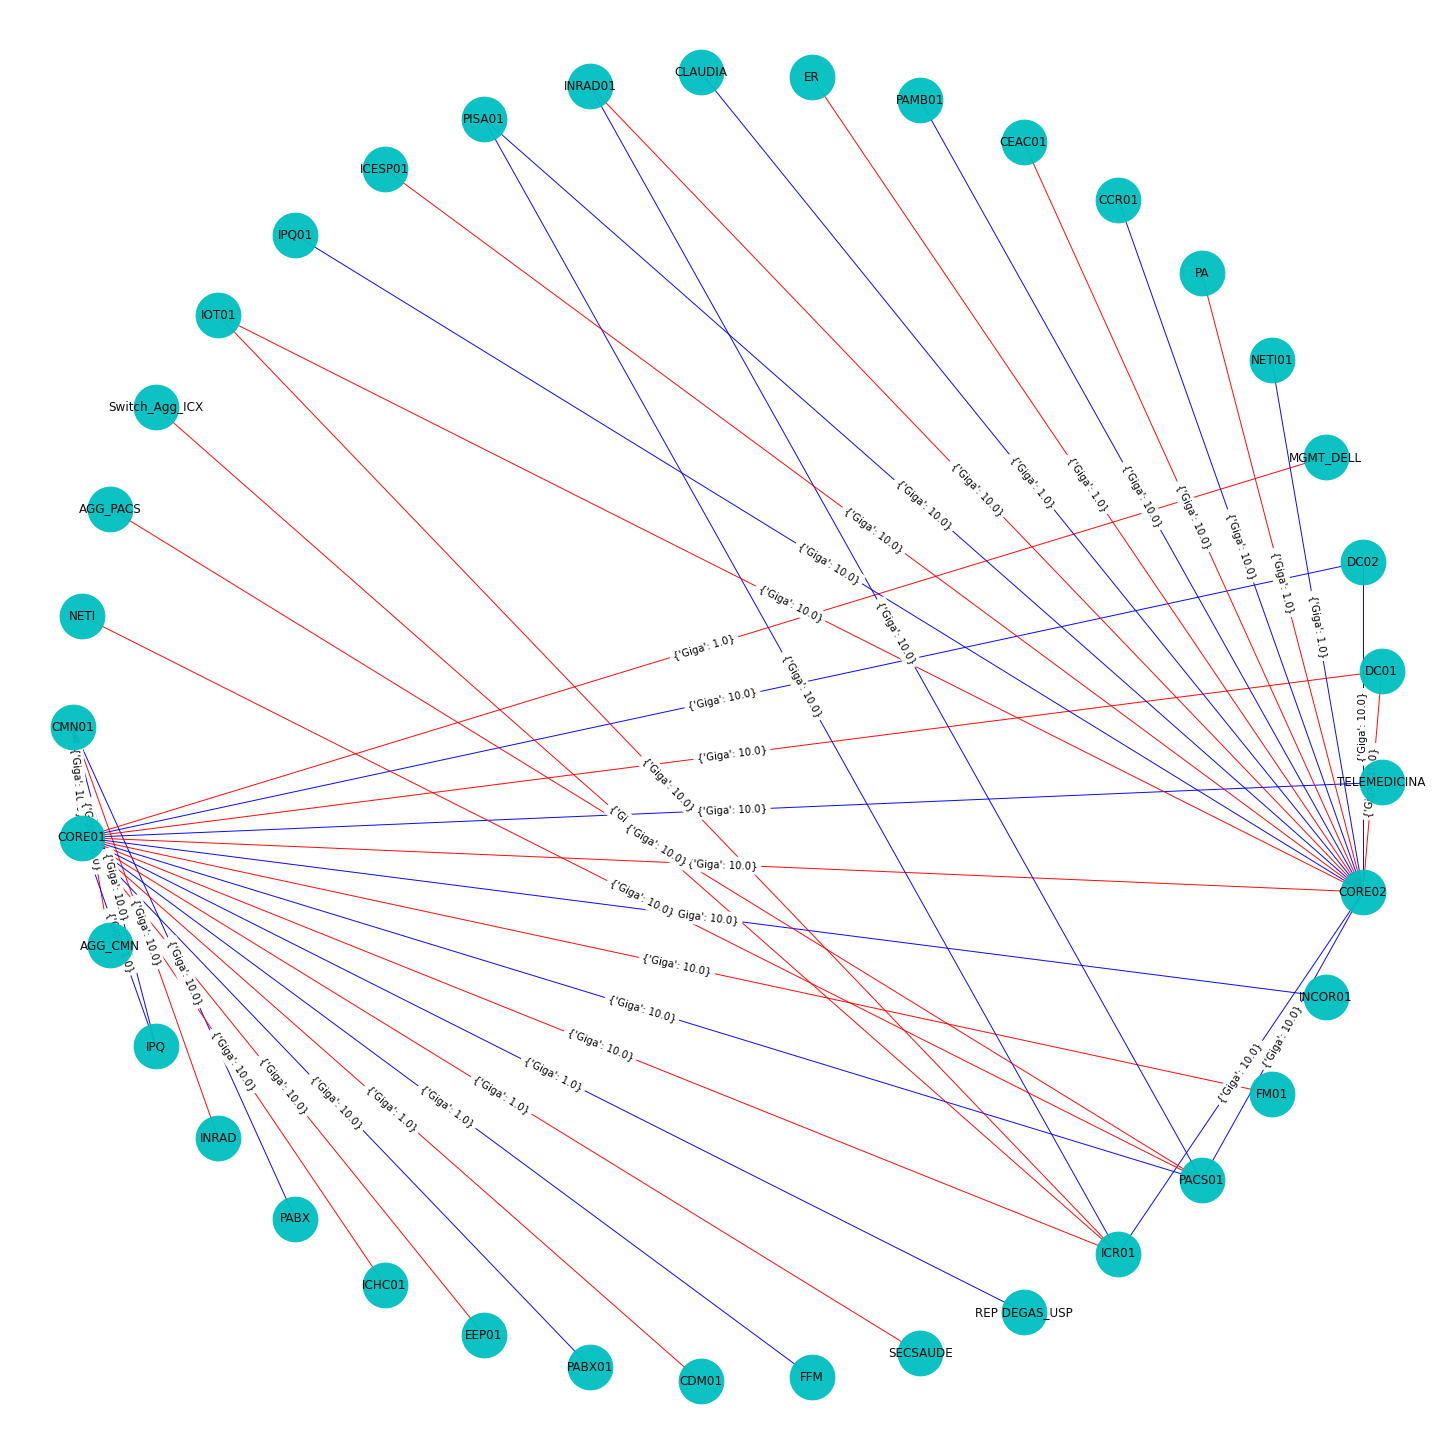

In [416]:
#chamada funções
def main():
    get_all_files()

#main
if __name__ == '__main__':
    main()